# Recommender systems:

are a subclass of information filtering system that seeks to predict the "rating" or "preference" that a user would give to an item. The netflix prize is one of the most well-known challenges, that fuelled research and development of new algorithms in these area. 

In this notebook, I'm implementing two of the main approaches to build recommender systems, namely the Memory based and model based collaborative filterings. So content is oganized as follows:

1. A brief __EDA__, focusing on users' rating behavior
2. __Memory based collaborative filtering__
   - Introducing Item-based ( and hint for User-based collaborative filtering)
3. __Model-based collaborative filtering__ using __matrix factorization__
   - SVD dimentionality reduction
   - __Alternating Least Square__ ( implemented in __Spark__)


Strat by importing basic modules

In [ ]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif',\
        font_scale=1.5, color_codes=False, rc=None )

In [ ]:
''' 
Reading in the rating dataframe
'''
df_rates = pd.read_csv('./input/ratings.csv')

In [3]:
df_rates.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


![](http://)

Dataframe contains, 3 columns. Next we'll look at the number of user and book ids:

In [4]:
n_users = df_rates.user_id.unique().shape[0]
n_items = df_rates.book_id.unique().shape[0]

print('%s users has rated of %s unique books.'%(str(n_users), str(n_items)))

53424 users has rated of 10000 unique books.


## Only choosing a subset of users and books to reduce computational time.
Randomly choose a subset of the 2d array


In [5]:
idx1 = np.random.randint(n_users, size=int0(n_users/2))
idx2= np.random.randint(n_items, size= n_items)

subdf_rates = df_rates[(df_rates['user_id'].isin(idx1)) & (df_rates['book_id'].isin(idx2))]

n_sub_u = subdf_rates.user_id.unique().shape[0]
n_sub_i = subdf_rates.book_id.unique().shape[0]
print('The selected subset of rating includs %s users and %s books.'%(n_sub_u, n_sub_i))

The selected subset of rating includs 20460 users and 6303 books.


# Distribution of the average ratings per user and per book


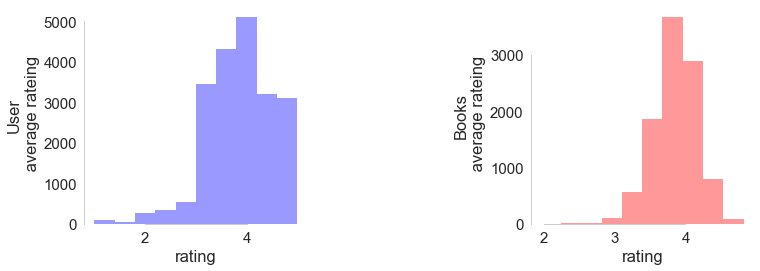

In [6]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
subplots_adjust(wspace=1)
g1 = subdf_rates.groupby('user_id')['rating'].mean()
g1 = subdf_rates.groupby('user_id', as_index=False)[['user_id', 'rating']].mean()

sns.distplot(g1.rating, bins =10, kde=False, color='b', ax=ax1);
ax1.set_ylabel("User\n average rateing")
ax1.grid(0)

g2 = df_rates.groupby('book_id', as_index=False)[['book_id', 'rating']].mean()
sns.distplot(g2.rating, bins =10, kde=False, color='r', ax=ax2);
ax2.set_ylabel("Books\n average rateing")
sns.despine(trim=True)
ax2.grid(0)

- Most books are mostly rated above 3, with a peak around 4.
- Most users are rating on average 3 and more.

# Distribution of the number of ratings per books

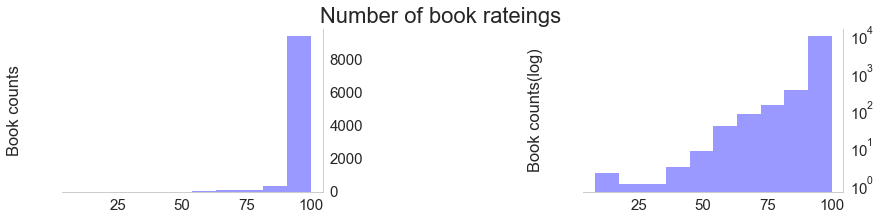

In [7]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))
subplots_adjust(wspace=1)

plt.suptitle("Number of book rateings", fontsize=22)

vals = list(dict(df_rates['book_id'].value_counts()).values())
sns.distplot(vals, bins =10, kde=False, color='blue',ax=ax1);
ax1.set_ylabel("Book counts", labelpad=40)

sns.despine(left=True, top=True, bottom=False, right=False)

ax1.grid(0)

sns.distplot(vals, bins =10, kde=False, color='blue',ax=ax2);
ax2.set_yscale('log')

ax2.set_ylabel("Book counts(log)", labelpad=40)
ax2.set_frame_on(1)
ax2.grid(0)

# Distribution of the number of ratings per user

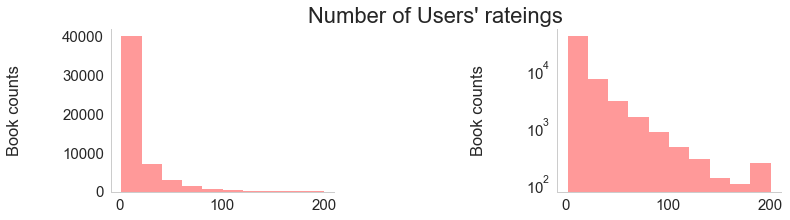

In [8]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
subplots_adjust(wspace=1)

plt.suptitle("Number of Users' rateings", fontsize=22)
vals = list(dict(df_rates['user_id'].value_counts()).values())

sns.distplot(vals, bins =10, kde=False, color='r', ax=ax1);
ax1.set_ylabel("Book counts", labelpad=40)
sns.despine(left=False, top=True, bottom=False, right=True)

ax1.grid(0)

sns.distplot(vals, bins =10, kde=False, color='r', ax=ax2);
ax2.set_ylabel("Book counts", labelpad=40)
ax2.set_yscale('log')

ax2.grid(0)


# EDA Conclusion and take-home messages:
    
- Books are mostly rated high. >3 with an average around 4.
   
- Users have mostly ranked between 3 and 5, a shorter tail around 5 and longer for ratings <3. This observationis consistant with the previous ones, as the whole pool of rating is the same and the difference in distribution, indicates the individualist differences of users' behavior, i.e., some are harder to satisfy than others.
   
- Many books ( order of $10^4$ ) recieve > 100 ratings and there are a few books with less than 50 ratings. But the distribution is different for users, where they mostly rated <10 books and there is a smaller fraction who has rated more than 100.

# Collaborative Filtering (CF)

In  one version of CF called __user-based CF__, we find user x who shares the interest on item $i_1$ and $i_2$ with you then if x likes item $i_3$, it's more likely that you're gonna like that item as well. In ML language, we find the similarities between two users based on a set of features, which in this case happens to be their rating behavior. (In fact a different variant of the Recommender systems called __ content-based Recommendation__ uses the meta-data for each book as its feature vector.)  

Same logic applies for the other simple form of CF, named the item-based collaborative filtering, where items similarity is assess based on they ranking’s they receive. 

The starting point in both these methods is to build a user-item matrix A, where element $A_{i,j}$ is the rating that user $i$ gave to item $j$. From here building the user-user and item-item similarity matrices is just to find the similarity of every pair of users, using some pairwise similarity metric. I will be using cosine-similarity in this notebook.

# Train/Test split for evaluation

In [9]:
from sklearn import model_selection
train_data, test_data = model_selection.train_test_split(subdf_rates, test_size=0.25, random_state=42)

train_idx = train_data.index
test_idx = test_data.index

In [10]:
''' 
To build the rating matrix using a numpy array the indices need to start from zero
'''
print("Min indices for user_id and item_id are %s and %s respectively."\
      %(df_rates.user_id.min(), df_rates.book_id.min()))

train_data_matrix0 = np.zeros((n_users, n_items))
test_data_matrix0 = np.zeros((n_users, n_items))

for line in subdf_rates.itertuples():
    if line.Index in train_idx:
        train_data_matrix0[line[2]-1, line[1]-1] = line[3]
    else: 
        test_data_matrix0[line[2]-1, line[1]-1] = line[3]

Min indices for user_id and item_id are 1 and 1 respectively.


In [11]:
train_data_matrix = train_data_matrix0[~np.all(train_data_matrix0 == 0, axis=1)]
test_data_matrix = test_data_matrix0[~np.all(test_data_matrix0 == 0, axis=1)]

In [12]:
''' Have a look at the shape of the reaing matrix'''
train_data_matrix.shape

(19641, 10000)

The resulting matrix is very sparse, since the possible combination of user-item ratings requires each user to rate around 10000 books. Let's compute the sparsity:

In [13]:
sparsity = int0(train_data_matrix>0).sum()
sparsity /= float(np.prod(train_data_matrix.shape))
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.09%


Only 0.02 % of the possible combinations of user-ratings exit.  

Scipy sparse module provides makes computations on sparse matrices very efficiect. Let's have a look at the performance difference between dense and the sparse matrix.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse as sp
import time

In [15]:
sub_mat = train_data_matrix[:10000,:1000]

st = time.time()
A_sparse = sp.csr_matrix(sub_mat)
similarities = cosine_similarity(A_sparse)
print("--- %s seconds for sparse implementation ---" %(time.time()-st))


st = time.time()
similarity = cosine_similarity(sub_mat)
print("--- %s seconds for dense implementation ---" %(time.time()-st))

--- 0.175879001617 seconds for sparse implementation ---
--- 4.26717591286 seconds for dense implementation ---


It takes 3 times longer for the computation _pairwise similarity_ for the dense matrix and the resulting matrices are the same:

In [16]:
np.allclose(similarities , similarity, atol=1e-18)

True

In [17]:
def get_pairwise_similarity(user_item_rating_matrix, type='user'):
    '''
    Given the user-item ranking matrix 
    Returns 'item' vs. 'user' based similarity matrix.
    '''
    if type == 'user':
        train_sparse = sp.csr_matrix(user_item_rating_matrix)
        similarity = cosine_similarity(train_sparse)


    elif type == 'item':
        train_sparse = sp.csr_matrix(user_item_rating_matrix.T)
        similarity = cosine_similarity(train_sparse)
    return similarity

In [18]:
st = time.time()

item_sims = get_pairwise_similarity(train_data_matrix, 'item')
user_sims = get_pairwise_similarity(train_data_matrix, 'user')
print("--- %s seconds for sparse implementation ---" %(time.time()-st))

--- 16.0721178055 seconds for sparse implementation ---


# Bias-subtracted CF


As we saw in the distribution of the average ratings for user, some users tend to rank higher, thus higher average rating. The same applies for books too. Therefore, the relative difference or deviation of a rating from the mean rating is a better indicator of the preference of the book than the absolute values the same applies for books.   



In [19]:
def predict_ratings(ratings, similarity, type='user'):
    '''
    Removing user/item tendencies for similiarities
    Returns prediction using the mean centered ratings
    '''
    if type == 'user':
        
        mean_user_bias = ratings.mean(axis=1)
        # new rating normalized by the difference from mean
        ratings = (ratings - mean_user_bias[:, np.newaxis]).copy() 
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += mean_user_bias[:, np.newaxis]
        
    elif type == 'item':
        
        mean_item_bias = ratings.mean(axis=0)
        # new rating normalized by the difference from mean
        ratings = (ratings - mean_item_bias[np.newaxis, :]).copy()
        
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += mean_item_bias[np.newaxis, :]
        
        
    return pred

In [20]:
st = time.time()

item_prediction = predict_ratings(train_data_matrix, item_sims, type='item')
user_prediction = predict_ratings(train_data_matrix, user_sims, type='user')
print("--- %s seconds for sparse implementation ---" %(time.time()-st))

/Users/admin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide


--- 234.626590014 seconds for sparse implementation ---


In [21]:
user_prediction = nan_to_num(user_prediction)

# Evaluation
To evaluate the accuracy of our results, we use the Root Mean Squared Error(RMSE). This is basically the mean of the squared differences of our actual vs. prediction values. Then, we compute the squared root to get values on the same scale as our actual values.

Also, for evalutation, we need to compare our predicteds ratings against the ratings that exist in the test dataset. Therefore, we should filter out all the zero elements in the prediction matrix. We use the following function:


In [22]:
from sklearn.metrics import mean_squared_error

def get_rmse(predict, actual):
    '''
    Computes root_mean_square_error for ratings in test dataset
    '''
    idx = actual.nonzero()
    predict = predict[idx].flatten()
    actual = actual[idx].flatten()
    return sqrt(mean_squared_error(predict, actual))

In [23]:
st = time.time()

print('User-based CF RMSE: ' + str(get_rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(get_rmse(item_prediction, test_data_matrix)))
(time.time()-st)

User-based CF RMSE: 3.96244882469
Item-based CF RMSE: 3.96305146704


4.733869791030884

RMSE can be interpreted as the average error in estimation. Thus, $RMSE \approx 4$ is quiet high, for the rating between 0 and 5. 

# $Top_{k}$  *CF*
In the last attempt, to improve our prediction we can replace the comparision and filtering of all users by only using a subset of the most similar users. For this all we need to do is to find the subset of most similar users/items and use that instead of the full similarity matrix.

In [24]:
def get_topk_similarity(similarity, k):
    '''
    Getting only the topk most similar items/users, given a similarity matrix
    '''
    top_ks = []
    for i in similarity:
        inds = i.argsort()[::-1][:k]
        mask = np.zeros(i.shape)
        mask[inds] = i[inds]
        top_ks += [mask]
        
    top_ks = array(top_ks)
    return top_ks

In [25]:
item_topk_sims = get_topk_similarity(item_sims, 15)
user_topk_sims = get_topk_similarity(user_sims, 15)

In [26]:
item_topk_pred = predict_ratings(train_data_matrix, item_topk_sims, type='item')
user_topk_pred = predict_ratings(train_data_matrix, user_topk_sims, type='user')

/Users/admin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide


In [27]:
item_topk_pred = nan_to_num(item_topk_pred)
user_topk_pred = nan_to_num(user_topk_pred)

print('Item-based Top 15 CF RMSE: ' + str(get_rmse(item_topk_pred, test_data_matrix)))
print('User-based Top 15 CF RMSE: ' + str(get_rmse(user_topk_pred, test_data_matrix)))

Item-based Top 15 CF RMSE: 3.96360554788
User-based Top 15 CF RMSE: 3.96401059594


To get the optimal value of the number of similar items we evaluate the RMSE for different number of similars and comparing it for training vs. test set. 


In [28]:
ks = [5, 10, 15, 30, 50, 100]

item_train_rmse = [] 
item_test_rmse = [] 

for k in ks:
    topk_item_similarity = get_topk_similarity(item_sims, k=k)
    
    item_pred = predict_ratings(train_data_matrix, topk_item_similarity, type='item')    
    item_pred = nan_to_num(item_pred)

    item_train_rmse += [get_rmse(item_pred, train_data_matrix)]
    item_test_rmse += [get_rmse(item_pred, test_data_matrix)]  


/Users/admin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide


In [29]:
ks += [max(ks)+20]
item_pred = predict_ratings(train_data_matrix, item_sims, type='item')    
item_pred = nan_to_num(item_pred)
item_train_rmse += [get_rmse(item_pred, train_data_matrix)]
item_test_rmse += [get_rmse(item_pred, test_data_matrix)]

/Users/admin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in divide


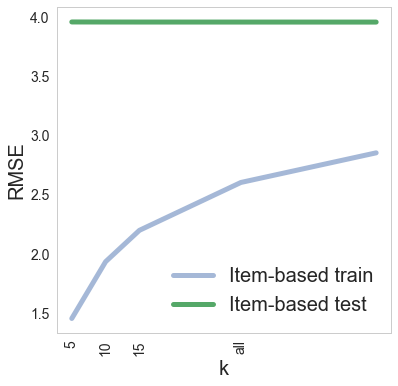

In [32]:
xticks = [str(k) for k in ks[:4]]
xticks[-1] = 'all'

fig =plt.figure(figsize=(6, 6))

ax = fig.gca
plt.plot(ks[:5], item_train_rmse[:5], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(ks[:5], item_test_rmse[:5], label='Item-based test', linewidth=5)

plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.xticks(ks[:5], xticks, rotation='vertical')

plt.xlabel('k', fontsize=20);
plt.ylabel('RMSE', fontsize=20);
plt.grid(0)

As can be seen the best RMSE for test set remains around $\sim 4$ and does not change with the number of similar items, while it's increasing for training set, a clear indicator of overfitting.



## Model-based Collaborative Filtering

Model-based CF methods are mostly build on the power of the matrix factorization (MF) technique, which refers to a class of dimensionality reduction algorithms and thus extremely useful in real-world cases with high-dimensionality and highly sparse data. 

__Singular Value Decomposition(SVD)__ is one of the simplest types of MF. Here we're going to try that.  

In [33]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
'''
k in the svds module corresponds the number of latent variable 
or the new dimension used to build the feature space
'''
u, s, vt = svds(train_data_matrix, k = 30)
s_diag_matrix = np.diag(s)
rate_pred_matrix = np.dot(np.dot(u, s_diag_matrix), vt)

In [34]:
print("Model Based SVD Train MSE for K=30 is %s: " %str(get_rmse(rate_pred_matrix, test_data_matrix)))
print('Model Based SVD Test MSE for K=30 is %s: ' %str(get_rmse(rate_pred_matrix, train_data_matrix)))

Model Based SVD Train MSE for K=30 is 3.96400528751: 
Model Based SVD Test MSE for K=30 is 3.74519594487: 


In [35]:
def get_svd_rate_prediction(rating, rank):
    u, s, vt = svds(rating, k = rank)
    s_diag_matrix = np.diag(s)
    rate_pred_matrix = np.dot(np.dot(u, s_diag_matrix), vt)
    return rate_pred_matrix

In [36]:
latents = [10, 20, 40, 80, 150, 250]
svd_train_rmse = []
svd_test_rmse = []

for k in latents:
   
    rating_svd_k = get_svd_rate_prediction(train_data_matrix, k)
    svd_train_rmse += [get_rmse(rating_svd_k, train_data_matrix)]
    svd_test_rmse += [get_rmse(rating_svd_k, test_data_matrix)]

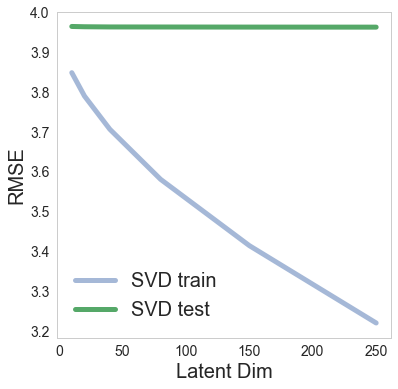

In [37]:
fig =plt.figure(figsize=(6, 6))

ax = fig.gca
plt.plot(latents, svd_train_rmse, label='SVD train', alpha=0.5, linewidth=5)
plt.plot(latents, svd_test_rmse, label='SVD test', linewidth=5)

plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel('Latent Dim', fontsize=20);
plt.ylabel('RMSE', fontsize=20);
plt.grid(0)

Using higher number of latent variables, seems to decrease the RMSE for training set while test set is not changing much, clear sign of overfitting.

Another method from the Matrix factorizaion family, used in known as the __Alternating Least Square method__. You can learn about it in this blog: https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/  

I'm going to use the Spark implementation of the Alternating Least Square included as ALS in mllib.recommendation. I'm using this both to utilize Sparks fast data processing capabilities, which in turns enables us to use the entire training dataset. rather than the subsets we were limited to use in the previous methods.

To run the ALS, we need to know the parameters of the model:
- rank is the number of latent factors in the model.
- iterations is the number of iterations to run.
- lambda specifies the regularization parameter in ALS.

First thing we need to create a SparkConf object which sets the configuration for a Spark application and set various Spark parameters as key-value pairs.
 

In [38]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("BookRating")
sc = SparkContext(conf = conf)

Then we load the rating datafram into a spark RDD object.

In [39]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df = sqlContext.createDataFrame(df_rates)

df.registerTempTable("df")

rdd = df.rdd
'''
Have a look at the RDD object
'''
rdd.take(5)

[Row(book_id=1, user_id=314, rating=5),
 Row(book_id=1, user_id=439, rating=3),
 Row(book_id=1, user_id=588, rating=5),
 Row(book_id=1, user_id=1169, rating=4),
 Row(book_id=1, user_id=1185, rating=4)]

In [40]:
''' 
Change the order to have user-item dataframe and later matrix?
'''
ratings_data = rdd.map(lambda tokens: (tokens[1],tokens[0],tokens[2])).cache()

Split the data to training, validation and test sets

In [41]:
training_RDD, validation_RDD, test_RDD = ratings_data.randomSplit([6, 2, 2], seed=0L)
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [42]:
from pyspark.mllib.recommendation import ALS

In [43]:
seed = 5L
iterations = 10
reg = 0.1
ranks = [4, 8, 16, 20, 40, 60, 80, 100]
# errors = [0, 0, 0]
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1
best_reg = -1
errors = np.zeros(len(ranks))
for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations,
                      lambda_=reg)
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print 'For reguliaziation paramter %s , rank %s the RMSE is %s' % (reg, rank, error)
    if error < min_error:
        min_error = error
        best_rank = rank
        best_reg = reg

print 'The best model was trained with rank %s' % best_rank

For reguliaziation paramter 0.1 , rank 4 the RMSE is 0.93744760674
For reguliaziation paramter 0.1 , rank 8 the RMSE is 0.946134618708
For reguliaziation paramter 0.1 , rank 16 the RMSE is 0.941025827545
For reguliaziation paramter 0.1 , rank 20 the RMSE is 0.934376873361
For reguliaziation paramter 0.1 , rank 40 the RMSE is 0.919200664761
For reguliaziation paramter 0.1 , rank 60 the RMSE is 0.910777600038
For reguliaziation paramter 0.1 , rank 80 the RMSE is 0.907603138302
For reguliaziation paramter 0.1 , rank 100 the RMSE is 0.90561967745
The best model was trained with rank 100


In [44]:
model = ALS.train(training_RDD, 4, seed=seed, iterations=iterations,
                      lambda_=reg)
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print 'For testing data the RMSE is %s' % (error)

For testing data the RMSE is 0.937819355122


In [45]:
print(model.userFeatures().count())
print(model.productFeatures().count())

51655
10000


We will use __productFeatures matrix__ to build an item-item collaborative filtering recommendation model.

# Building book recommenders

First see what information do we get about the book:

In [47]:
df_books = pd.read_csv('./input/'+'books.csv')
df_books.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [48]:
''' 
Remember that to build the rating matrices we converted indices to start from zero
Thus we first convert the book_id s to be on the same scale
'''
books_info = df_books['book_id'].apply(lambda l: l-1).tolist()

# Books that have both rating and meta-data available 

We have book ids for the books in the rating dataframe and then books for which we have additoinal data available in book_df. 

In [49]:
df_rates.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [50]:
books_w_data = pd.merge(df_rates, df_books, on='book_id')

In [51]:
common_bookids = books_w_data['book_id'].unique().tolist()

print("Only %s books have both rating and meta-data available."%str(len(common_bookids)))

Only 812 books have both rating and meta-data available.


In [52]:
'''
Dict to map book_ids to books names
'''
book_names_dict = dict(zip(books_w_data.book_id.apply(lambda l: l-1), books_w_data.original_title))

Let's look at a example, I chose book_id = 2657, which happens to be one of my faviorite books of all times.

In [168]:
itemId = 2657-1  # subtract by 1 to match the mapping

print("Book:", book_names_dict[itemId])

('Book:', 'To Kill a Mockingbird')


We can then get the feature vector in the space of latent feature:

In [62]:
itemFactor = np.asarray(model.productFeatures().lookup(itemId))[0]

In [55]:
def cosineSimilarity(vec1, vec2):
    vec1 = np.asarray(vec1)
    vec2 = np.asarray(vec2)
    return cosine_similarity(vec1.reshape(1,-1), vec2.reshape(1,-1))[0][0]

Given the feature vector for this book, we can know compute it's similarity with all the other books in the dataset.

In [56]:
def get_items_similarity(item_id, model=model, books_w_info=books_info):
    '''
    Takes as input: 
            a book_id (item_id)  
            the trained ALS model (model)
            and the list of books for which we have extra info (books_w_info)
    Returns:
            cosine similarity of the book_id to all the other books with the info
    
    '''
    
    itemFactor = np.asarray(model.productFeatures().lookup(item_id-1))[0]
    return model.productFeatures().filter(lambda product: product[0] in books_w_info).map(lambda product:
                                    (product[0], cosineSimilarity(product[1], itemFactor)))

In [58]:
sims= get_items_similarity(itemId)

In [63]:
''' 
Number of items in the sims rdd
'''
sims.count(), sims.take(2)

(811, [(1, 0.90642435178118186), (2, 0.79492329379876547)])

For the similar books we can look at some further meta-data/stats info. Here we're gonna look at:
    1. Book title 
    2. Number of rating the book has recieved (populatity)
    3. Average rating for the book

In [64]:
def get_counts_and_averages(ID_and_ratings_tuple):
    '''
    given the movie: ratings RDD
    returns: (movies_id, number of ratings, average rating)
    '''
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

In [65]:
def get_movie_id_count_average_ratings_allbooks(ratings_data):
    
    ## 1) movie ratings RDD
    movie_ID_with_ratings_RDD = ratings_data.map(lambda x: (x[1], x[2])).groupByKey()

    ## 2) apply function to get count/average
    movie_ID_with_count_avg_RDD = movie_ID_with_ratings_RDD.map(get_counts_and_averages)

    return movie_ID_with_count_avg_RDD

Then to be more concise let's just focus on the top $K=10$ most simialr books, for each given book. 
Also we're gonna only consider books with at least 20 ratings. It the books is not popular enough we might as well not recommend it. 

In [152]:
def get_count_ave_rates_topk(all_sims, topk_books, ratings= ratings_data, min_rating_count=10):
    '''
    Given the similarity of each book to all the other books in the dataset
    Return a list of topk most similar books
    '''
    n = min_rating_count
    
    movie_ID_with_count_avg_RDD = get_movie_id_count_average_ratings_allbooks(ratings)
    ## 4) merge similarity count and average ratings
    sims_count_ave = all_sims.join(movie_ID_with_count_avg_RDD)#(movie_rating_counts_RDD)

    ## 5) getting the books with at least n=20 ratings
    complete_sortedSims = sims_count_ave.filter(lambda r: r[1][1][0]>n)\
                    .takeOrdered(topk_books+1, key=lambda x: -x[1][0])
    return complete_sortedSims

In [153]:
def get_df_topK_similars(book_id, top_k):
    
    all_sims= get_items_similarity(book_id)
    top10s = get_count_ave_rates_topk(all_sims, top_k)
    tops10_df = get_booktitle_image_4_topk(top10s)
    return tops10_df

In [154]:
def topk_ls_2_df(topk_sims):
    itms_ids = zip(*topk_sims)[0]
    sim_vals = zip(*zip(*topk_sims)[1])[0]
    cnt_r = zip(*zip(*zip(*topk_sims)[1])[1])[0]
    ave_r = zip(*zip(*zip(*topk_sims)[1])[1])[1]

    ls_2_df = pd.DataFrame({'book_id':itms_ids, 'SimVal':sim_vals,\
                       'RevCount': cnt_r, 'RevAve':ave_r})

    ls_2_df['book_id'] =ls_2_df['book_id'].apply(lambda l: l+1) 
    return ls_2_df

In [155]:
def get_booktitle_image_4_topk(book_id, topk, book_info_df=df_books):
    all_sims = get_items_similarity(book_id)
    topk_sims = get_count_ave_rates_topk(all_sims, topk)
    ls_2_tbl = topk_ls_2_df(topk_sims)
    ls_2_tbl = ls_2_tbl.merge(book_info_df, on='book_id')[['image_url', 'title',  'RevAve', 'RevCount', 'SimVal']]
    ls_2_tbl.columns = ['Image', 'Book Title', 'Average Rating', 'Rating Count', 'Similarity']
    return ls_2_tbl

In [174]:
'''
Let's look at the top 10 books most similar to the "Harry Potter and the Philosopher's Stone"

'''
itemId = 3-1
print("Book:", book_names_dict[itemId]) # subtract by 1 to match the mapping

('Book:', "Harry Potter and the Philosopher's Stone")


In [177]:
draw_df = get_booktitle_image_4_topk(itemId, 10)

In [178]:
from IPython.display import Image, HTML

def path_to_image_html(path):
    return '<img src="'+ path + '"/>'
pd.set_option('display.max_colwidth', -1)

HTML(draw_df.to_html(escape=False ,formatters=dict(Image=path_to_image_html)))

,Image,Book Title,Average Rating,Rating Count,Similarity
0,,"Harry Potter and the Order of the Phoenix (Harry Potter, #5)",4.240000,100,1.000000
1,,"The Dark Tower (The Dark Tower, #7)",3.830000,100,0.999754
2,,The Taste of Home Cookbook,3.930000,100,0.999202
3,,The Lover,4.030000,100,0.998928
4,,As the Crow Flies,3.590164,61,0.998653
5,,Don't Make Me Think: A Common Sense Approach to Web Usability,3.920000,100,0.998221
6,,"Endymion (Hyperion Cantos, #3)",3.600000,100,0.997038
7,,The Bookseller of Kabul,3.357143,98,0.996804
8,,"Casino Royale (James Bond, #1)",3.520000,100,0.996503
9,,"Fire Sea (The Death Gate Cycle, #3)",3.200000,100,0.996262


Future work:
    
The most recent line of research on Recommender Systems, uses the new advances in the deep learning area, for instance, using __Deep Neural Network__ with autho-encoders: http://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf As next step I'd like to give that a try an implement it using TensorFlow!